## Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import pandas as pd
import numpy as np
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import psutil
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

d:\Perkuliahan\Sem 7\Pembelajaran Mendalam\Week 12\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device Setup & Reproducibility

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

# Optional: set seeds
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

output_dir = "DeiT Tiny"
os.makedirs(output_dir, exist_ok=True)

✅ Using device: cuda


## Data Preparation

In [3]:
# Use ImageNet normalization + resize to 224x224 (required by DeiT Tiny)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

transform_test = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    normalize
])

# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Train: {len(train_dataset)} images | Test: {len(test_dataset)} images")

✅ Train: 50000 images | Test: 10000 images


## Model Setup – Load Pretrained

In [4]:
# Load DeiT Tiny from timm (pretrained on ImageNet-1k)
print("📥 Loading DeiT Tiny from timm...")
model = timm.create_model(
    'deit_tiny_distilled_patch16_224.fb_in1k',
    pretrained=True,
    num_classes=10
)

# Freeze all but the head
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

model = model.to(device)
print("✅ Model output shape test:", model(torch.randn(1, 3, 224, 224).to(device)).shape)

📥 Loading DeiT Tiny from timm...
✅ Model output shape test: torch.Size([1, 10])


In [5]:
def get_model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024 ** 2)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params
model_size_mb = get_model_size_mb(model)

print("=== MODEL PARAMETER ===")
print(f"• Total Parameters:         {total_params:,}")
print(f"• Trainable Parameters:     {trainable_params:,}")
print(f"• Non-Trainable Parameters: {non_trainable_params:,}")
print(f"• Model Size (FP32):        {model_size_mb:.2f} MB")

=== MODEL PARAMETER ===
• Total Parameters:         5,528,660
• Trainable Parameters:     3,860
• Non-Trainable Parameters: 5,524,800
• Model Size (FP32):        21.09 MB


## Training Configuration

In [6]:
NUM_EPOCHS = 20
best_val_acc = 0.0

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Track metrics for learning curves
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

## Training & Validation Loop

In [7]:
def evaluate_loader(loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(loader)
    return avg_loss, acc, all_preds, all_labels

# Training loop
print("🚀 Starting training...\n")
total_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    
    # --- Training ---
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = outputs.max(1)
        train_total += labels.size(0)
        train_correct += preds.eq(labels).sum().item()
    
    train_acc = train_correct / train_total
    train_loss /= len(train_loader)
    
    # --- Validation ---
    val_loss, val_acc, _, _ = evaluate_loader(test_loader)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_path = os.path.join(output_dir, "deit_tiny_cifar10_best.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Epoch {epoch+1}: 🥇 New best accuracy! Saved model.")
    
    # Update LR
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f} | "
        f"LR: {current_lr:.2e}\n"
    )

total_time = time.time() - total_start_time
print(f"\n✅ Training finished. Best validation accuracy: {best_val_acc:.2f}")
print(f"🕒 Total training time: {total_time/60:.2f} minutes")

🚀 Starting training...

Epoch 1: 🥇 New best accuracy! Saved model.
Epoch 1/20 | Train Loss: 0.8064, Acc: 0.89 | Val Loss: 0.7498, Acc: 0.91 | LR: 9.94e-04

Epoch 2: 🥇 New best accuracy! Saved model.
Epoch 2/20 | Train Loss: 0.7461, Acc: 0.92 | Val Loss: 0.7441, Acc: 0.92 | LR: 9.76e-04

Epoch 3/20 | Train Loss: 0.7427, Acc: 0.92 | Val Loss: 0.7461, Acc: 0.92 | LR: 9.46e-04

Epoch 4/20 | Train Loss: 0.7407, Acc: 0.92 | Val Loss: 0.7454, Acc: 0.91 | LR: 9.05e-04

Epoch 5: 🥇 New best accuracy! Saved model.
Epoch 5/20 | Train Loss: 0.7406, Acc: 0.92 | Val Loss: 0.7426, Acc: 0.92 | LR: 8.54e-04

Epoch 6: 🥇 New best accuracy! Saved model.
Epoch 6/20 | Train Loss: 0.7394, Acc: 0.92 | Val Loss: 0.7469, Acc: 0.92 | LR: 7.94e-04

Epoch 7/20 | Train Loss: 0.7389, Acc: 0.92 | Val Loss: 0.7449, Acc: 0.92 | LR: 7.27e-04

Epoch 8/20 | Train Loss: 0.7386, Acc: 0.92 | Val Loss: 0.7432, Acc: 0.92 | LR: 6.55e-04

Epoch 9/20 | Train Loss: 0.7377, Acc: 0.92 | Val Loss: 0.7450, Acc: 0.91 | LR: 5.79e-04

Epo

## Performance Metrics

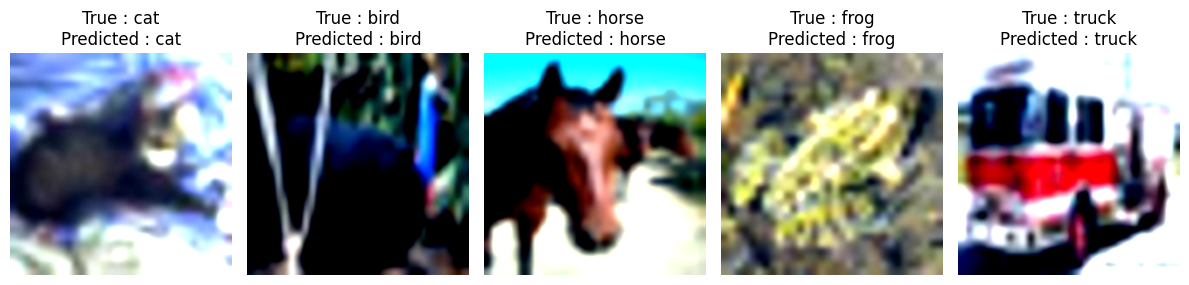

In [8]:
model_path = os.path.join(output_dir, "deit_tiny_cifar10_best.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Get predictions
all_preds, all_labels, all_images = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = probs.max(1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu())

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Convert to numpy arrays
all_images = torch.stack(all_images).numpy()
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Show 5 random samples
idxs = np.random.choice(len(all_labels), 5, replace=False)
plt.figure(figsize=(12, 4))
for i, idx in enumerate(idxs):
    img = np.transpose(all_images[idx], (1, 2, 0))  # C,H,W → H,W,C
    img = np.clip((img * 0.5 + 0.5), 0, 1)

    true_label = class_names[all_labels[idx]]
    pred_label = class_names[all_preds[idx]]

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True : {true_label}\nPredicted : {pred_label}")

plt.tight_layout()
plt.show()

In [9]:
# Save to CSV
df = pd.DataFrame({
    'image_id': list(range(len(all_labels))),
    'true_label': [class_names[i] for i in all_labels],
    'predicted_label': [class_names[i] for i in all_preds],
})
csv_path = os.path.join(output_dir, "predictions.csv")
df.to_csv(csv_path, index=False)
print("✅ Predictions saved to 'predictions.csv'")

✅ Predictions saved to 'predictions.csv'


In [10]:
acc = accuracy_score(all_labels, all_preds)
prec_macro = precision_score(all_labels, all_preds, average='macro')
rec_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print("\n=== PERFORMANCE METRICS ===")
print(f"• Overall Accuracy: {acc:.4f} ({100*acc:.2f}%)")
print(f"• Macro Precision:  {prec_macro:.4f}")
print(f"• Macro Recall:     {rec_macro:.4f}")
print(f"• Macro F1-Score:   {f1_macro:.4f}")

# Per-class
prec_per = precision_score(all_labels, all_preds, average=None)
rec_per = recall_score(all_labels, all_preds, average=None)
f1_per = f1_score(all_labels, all_preds, average=None)

print("\n• Per-Class Metrics:")
print("Class\t\tPrecision\tRecall\t\tF1")
for i, name in enumerate(class_names):
    print(f"{name:<12}\t{prec_per[i]:.4f}\t\t{rec_per[i]:.4f}\t\t{f1_per[i]:.4f}")


=== PERFORMANCE METRICS ===
• Overall Accuracy: 0.9189 (91.89%)
• Macro Precision:  0.9189
• Macro Recall:     0.9189
• Macro F1-Score:   0.9188

• Per-Class Metrics:
Class		Precision	Recall		F1
airplane    	0.9234		0.9280		0.9257
automobile  	0.9470		0.9470		0.9470
bird        	0.9322		0.8800		0.9053
cat         	0.8582		0.8410		0.8495
deer        	0.9005		0.9230		0.9116
dog         	0.8738		0.8860		0.8798
frog        	0.9277		0.9500		0.9387
horse       	0.9383		0.9280		0.9331
ship        	0.9495		0.9590		0.9542
truck       	0.9386		0.9470		0.9428


## Confusion Matrix

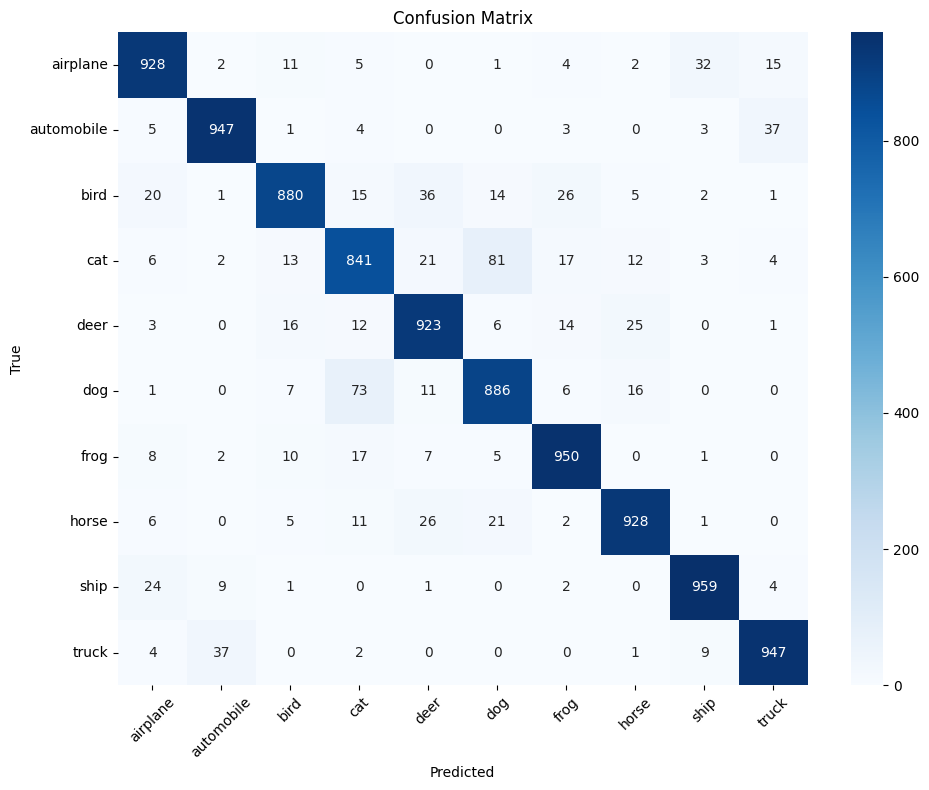

In [11]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Learning Curves

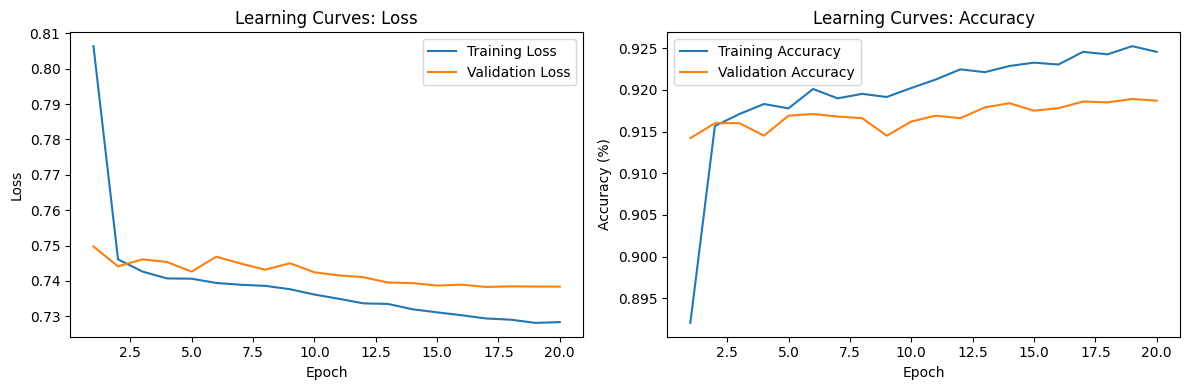

In [12]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Learning Curves: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Training Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Learning Curves: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## Inference

In [13]:
# Warm-up
model.eval()
with torch.no_grad():
    for _ in range(10):
        x, _ = next(iter(test_loader))
        x = x.to(device)
        _ = model(x)

# Timed inference on full test set
start_time = time.time()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        _ = model(x)
end_time = time.time()

total_time = end_time - start_time
total_images = len(test_dataset)
avg_time_per_image_ms = (total_time / total_images) * 1000
throughput = total_images / total_time

print("=== INFERENCE TIME ===")
print(f"• Total test images:       {total_images}")
print(f"• Total inference time:    {total_time:.3f} sec")
print(f"• Avg. time per image:     {avg_time_per_image_ms:.3f} ms")
print(f"• Throughput:              {throughput:.2f} images/sec")

# Hardware info
if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print(f"• Hardware:                GPU - {gpu_name}")
else:
    cpu_count = psutil.cpu_count(logical=False)
    print(f"• Hardware:                CPU - {cpu_count} cores")

=== INFERENCE TIME ===
• Total test images:       10000
• Total inference time:    9.322 sec
• Avg. time per image:     0.932 ms
• Throughput:              1072.68 images/sec
• Hardware:                GPU - NVIDIA GeForce RTX 5060 Laptop GPU
